In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses, Input, optimizers, metrics
from keras_tuner.tuners import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
import sys
sys.path.append('../')

from utils.tensorflow_preprocessing import prepare_image_target_dataset

tf.__version__

'2.15.1'

In [2]:
dataset_path = '../data/processed/csv'

train_X = pd.read_csv(f"{dataset_path}/train_X.csv")
val_X = pd.read_csv(f"{dataset_path}/val_X.csv")
test_X = pd.read_csv(f"{dataset_path}/test_X.csv")

print(f"train_X.shape: {train_X.shape}, val_X.shape: {val_X.shape}, test_X.shape: {test_X.shape}")

train_X.shape: (54048, 9), val_X.shape: (18017, 9), test_X.shape: (18017, 9)


In [3]:
BATCH_SIZE = 16

In [4]:
train_class_ds, style_encoder = prepare_image_target_dataset(train_X, target_name="Style", batch_size=BATCH_SIZE)
val_class_ds, _ = prepare_image_target_dataset(val_X, target_name="Style", label_encoder=style_encoder, batch_size=BATCH_SIZE)
test_class_ds, _ = prepare_image_target_dataset(test_X, target_name="Style", label_encoder=style_encoder, batch_size=BATCH_SIZE)

In [5]:
# If training crash due to RAM usage
options = tf.data.Options()

# Stop magic stuff that eats up RAM:
options.autotune.enabled = False
options.experimental_distribute.auto_shard_policy = (
    tf.data.experimental.AutoShardPolicy.OFF)
options.experimental_optimization.inject_prefetch = False

train_class_ds = train_class_ds.with_options(options)
val_class_ds = val_class_ds.with_options(options)
test_class_ds = test_class_ds.with_options(options)

In [6]:
# Basic Model Training
def create_model():
    this_model = models.Sequential([
        Input(shape=(256, 256, 3)),
        layers.Conv2D(4, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(8, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (4, 4), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (4, 4), activation='relu'),
        layers.GlobalMaxPooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5, seed=21),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5, seed=42),
        layers.Dense(17, activation='sigmoid')
    ])

    this_model.compile(optimizer='adam',
                  loss=losses.BinaryCrossentropy(from_logits=False),
                  metrics=[
                      metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Precision(name='precision'),
                      metrics.Recall(name='recall'),
                      metrics.AUC(name='auc'),
                  ])

    return this_model


In [7]:
# Train the model
basic_model = create_model()
epochs = 10
history = basic_model.fit(train_class_ds, epochs=epochs, batch_size=BATCH_SIZE, validation_data=val_class_ds)



Epoch 1/10

3378/3378 [==============================] - 116s 34ms/step - loss: 0.2013 - accuracy: 0.9398 - precision: 0.1051 - recall: 0.0032 - auc: 0.7627 - val_loss: 0.1837 - val_accuracy: 0.9412 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8188
Epoch 2/10
3378/3378 [==============================] - 116s 34ms/step - loss: 0.1834 - accuracy: 0.9413 - precision: 0.5341 - recall: 0.0110 - auc: 0.8189 - val_loss: 0.1709 - val_accuracy: 0.9424 - val_precision: 0.6368 - val_recall: 0.0470 - val_auc: 0.8540
Epoch 3/10
3378/3378 [==============================] - 116s 34ms/step - loss: 0.1754 - accuracy: 0.9422 - precision: 0.6108 - recall: 0.0460 - auc: 0.8402 - val_loss: 0.1673 - val_accuracy: 0.9434 - val_precision: 0.6377 - val_recall: 0.0884 - val_auc: 0.8620
Epoch 4/10
3378/3378 [==============================] - 120s 35ms/step - loss: 0.1713 - accuracy: 0.9428 - precision: 0.6274 - recall: 0.0697 - auc: 0.8495 - val_loss: 0.1643 - val_accuracy: 0.9437 - val_pr

In [8]:
# Evaluate the model
test_metrics = basic_model.evaluate(test_class_ds)
test_loss, test_accuracy, test_precision, test_recall, test_auc = test_metrics

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test AUC: {test_auc:.4f}')

1127/1127 [==============================] - 17s 15ms/step - loss: 0.1589 - accuracy: 0.9451 - precision: 0.6743 - recall: 0.1289 - auc: 0.8769
Test Loss: 0.1589
Test Accuracy: 0.9451
Test Precision: 0.6743
Test Recall: 0.1289
Test AUC: 0.8769


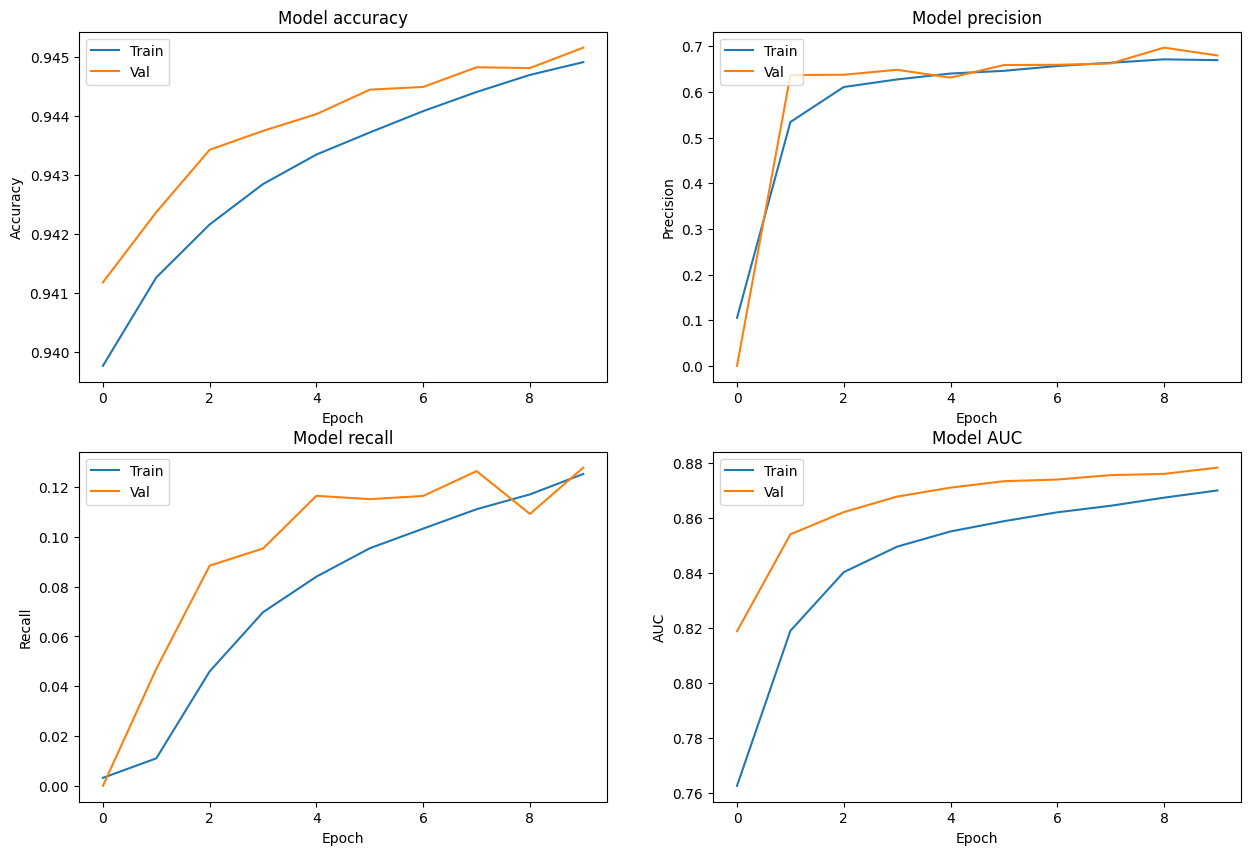

In [9]:
# Visualize the training history of the basic model
def plot_training_history(hist):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training & validation accuracy values
    axs[0, 0].plot(hist.history['accuracy'])
    axs[0, 0].plot(hist.history['val_accuracy'])
    axs[0, 0].set_title('Model accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation precision values
    axs[0, 1].plot(hist.history['precision'])
    axs[0, 1].plot(hist.history['val_precision'])
    axs[0, 1].set_title('Model precision')
    axs[0, 1].set_ylabel('Precision')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation recall values
    axs[1, 0].plot(hist.history['recall'])
    axs[1, 0].plot(hist.history['val_recall'])
    axs[1, 0].set_title('Model recall')
    axs[1, 0].set_ylabel('Recall')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation AUC values
    axs[1, 1].plot(hist.history['auc'])
    axs[1, 1].plot(hist.history['val_auc'])
    axs[1, 1].set_title('Model AUC')
    axs[1, 1].set_ylabel('AUC')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['Train', 'Val'], loc='upper left')

    plt.show()

plot_training_history(history)

1/1 [==============================] - 0s 172ms/step


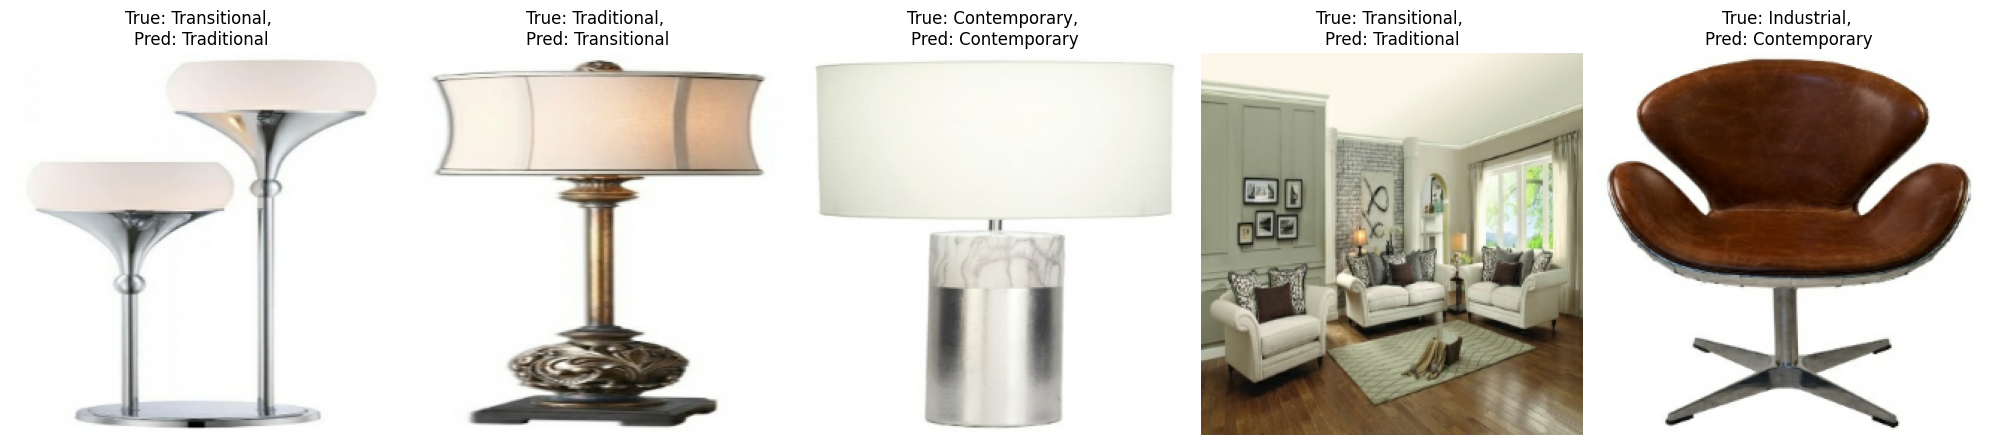

In [10]:

class_labels = ['Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial', 'Media', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian', 'Southwestern', 'Traditional', 'Transitional', 'Tropical', 'Victorian']

def visualize_predictions(model, test_data, class_labels, threshold=0.3, num_samples=5):
    for images, labels in test_data.take(1):
        predictions = model.predict(images)
        
        plt.figure(figsize=(20, 15))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow((images[i].numpy() * 255).astype('uint8'))
            
            true_label_indices = np.where(labels[i].numpy() == 1)[0]
            true_labels = [class_labels[idx] for idx in true_label_indices]
            
            pred_label_probs = predictions[i]
            sorted_indices = np.argsort(-pred_label_probs)
            pred_label_indices = np.where(pred_label_probs > threshold)[0]
            if pred_label_indices.size == 0:
                pred_label_indices = sorted_indices[:1]
            pred_labels = [class_labels[idx] for idx in pred_label_indices]
            
            plt.title(f"True: {', '.join(true_labels)}, \nPred: {', '.join(pred_labels)}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

visualize_predictions(basic_model, test_class_ds, class_labels)

In [11]:
from pathlib import Path

# Create paths
model_path = '../data/models'
processed_model_dir = Path(model_path)
processed_model_dir.mkdir(parents=True, exist_ok=True)

basic_model.save(model_path + '/' + 'task-3-CNN.keras')

In [12]:
encoder_path = '../data/label_encoders'
label_encoder_dir = Path(encoder_path)
label_encoder_dir.mkdir(parents=True, exist_ok=True)

np.save(encoder_path + "/" + 'style_encoder.npy', style_encoder.categories_)